In [1]:
import sys
import os
#import tensorflow_io as tfio
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import math
import numpy as np
import scipy.signal
#import pyloudnorm as pyln
from numba import jit 
#from pesq import pesq

import numpy as np

#import tensorflow_io as tfio
#from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import keras
from keras import layers
#from keras.applications import EfficientNetV2L
#from keras import ops

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import librosa.display
import IPython.display as ipd

print(tf.__version__)

2.15.0


In [4]:
# Setting Sample Rate and Number of Self-Generated Samples for Training

samples_per=24000
num_samples=50

In [254]:
# Assuming peq_arg is an array of neural network outputs, each between 0 and 1
peq_arg = np.random.rand()  # Example neural network outputs

# Minimum and maximum frequency values for the mapping, considering human hearing range and Nyquist theorem
min_freq = 20
max_freq = 12000
#peq_arg = 

# Calculate the cutoff/mid frequencies for each band
# The formula is adjusted for each band to cover different parts of the frequency spectrum
first_band_mid_freq = 16 + (np.exp(peq_arg) - 1)  / (np.e - 1) * (128-16)
second_band_mid_freq = 128 + (np.exp(peq_arg) - 1) / (np.e - 1) * (512 - 128) 
third_band_mid_freq = 512+ (np.exp(peq_arg) - 1)  / (np.e - 1) * (1024 - 512) 
fourth_band_mid_freq = 1024 + (np.exp(peq_arg) - 1)  / (np.e - 1) * (2048 - 1024)
fifth_band_mid_freq = 2048 + (np.exp(peq_arg) - 1) / (np.e - 1) * (4096 - 2048) 
sixth_band_mid_freq = 4096 + (np.exp(peq_arg) - 1)  / (np.e - 1) * (10240 - 4096)

# Display the calculated mid-frequencies for each band
print(f"1st Band Mid-Frequency: {first_band_mid_freq:.2f} Hz")
print(f"2nd Band Mid-Frequency: {second_band_mid_freq:.2f} Hz")
print(f"3rd Band Mid-Frequency: {third_band_mid_freq:.2f} Hz")
print(f"4th Band Mid-Frequency: {fourth_band_mid_freq:.2f} Hz")
print(f"5th Band Mid-Frequency: {fifth_band_mid_freq:.2f} Hz")
print(f"6th Band Mid-Frequency: {sixth_band_mid_freq:.2f} Hz")

1st Band Mid-Frequency: 42.74 Hz
2nd Band Mid-Frequency: 219.68 Hz
3rd Band Mid-Frequency: 634.24 Hz
4th Band Mid-Frequency: 1268.49 Hz
5th Band Mid-Frequency: 2536.98 Hz
6th Band Mid-Frequency: 5562.94 Hz


In [5]:
#Test Functuons
from scipy.signal import stft
from scipy.signal import square

def generate_signal(duration=1.0, fs=samples_per):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    # White noise
    signal = np.random.normal(0, 1, t.shape)
    # Overlay with square signals
    for _ in range(np.random.randint(1, 5)):  # Random number of square signals
        freq = np.random.randint(100, 1000)  # Random frequency
        start = np.random.randint(0, len(t) // 2)
        end = start + np.random.randint(fs // 10, fs // 2)
        signal[start:end] += square(2 * np.pi * freq * t[start:end])
    return t, signal

def visualize_signals_stft(original, processed, sr=samples_per):  # Assuming default sample rate of 22050 if not specified
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Original Signal
    S = np.abs(librosa.stft(original, n_fft=2048, hop_length=512))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='log', 
                                   ax=axs[0], vmin=-80, vmax=20)  # Adjusted dB range with vmin and vmax
    axs[0].set(title='Original Signal STFT')
    fig.colorbar(img, ax=axs[0], format='%+2.0f dB')

    # Processed Signal
    S_func = np.abs(librosa.stft(processed, n_fft=2048, hop_length=512))
    S_func_dB = librosa.amplitude_to_db(S_func, ref=np.max)
    img = librosa.display.specshow(S_func_dB, sr=sr, hop_length=512, x_axis='time', y_axis='log', 
                                   ax=axs[1], vmin=-80, vmax=20)  # Adjusted dB range with vmin and vmax
    axs[1].set(title='Processed Signal STFT')
    fig.colorbar(img, ax=axs[1], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

def visualize_signals_rms(original, processed, sr=samples_per):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Compute RMS for the original signal
    rms_original = librosa.feature.rms(y=original)[0]
    times_original = librosa.times_like(rms_original, sr=sr)
    axs[0].plot(times_original, rms_original)
    axs[0].set(title='Original Signal RMS Energy Over Time')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('RMS Energy')
    axs[0].set_ylim(0,3)

    # Compute RMS for the processed signal
    rms_processed = librosa.feature.rms(y=processed)[0]
    times_processed = librosa.times_like(rms_processed, sr=sr)
    axs[1].plot(times_processed, rms_processed)
    axs[1].set(title='Processed Signal RMS Energy Over Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('RMS Energy')
    axs[1].set_ylim(0,3)

    plt.tight_layout()
    plt.show()

PEQ

In [6]:
#Biquad Implementation
#@jit(nopython=True)
def biqaud(
    gain_dB,
    cutoff_freq,
    q_factor,
    sample_rate,
    filter_type,
):

    
    """Use design parameters to generate coeffieicnets for a specific filter type.

    Args:
        gain_dB (float): Shelving filter gain in dB.
        cutoff_freq (float): Cutoff frequency in Hz.
        q_factor (float): Q factor.
        sample_rate (float): Sample rate in Hz.
        filter_type (str): Filter type.
            One of "low_shelf", "high_shelf", or "peaking"

    Returns:
        b (np.ndarray): Numerator filter coefficients stored as [b0, b1, b2]
        a (np.ndarray): Denominator filter coefficients stored as [a0, a1, a2]
    """

    dtype=np.float32
    A = 10 ** (gain_dB / 40.0)
    w0 = 2.0 * np.pi * (cutoff_freq / sample_rate)
    alpha = np.sin(w0) / (2.0 * q_factor)

    cos_w0 = np.cos(w0)
    sqrt_A = np.sqrt(A)

    if filter_type == 0: #high-shelf
        b0 = A * ((A + 1) + (A - 1) * cos_w0 + 2 * sqrt_A * alpha)
        b1 = -2 * A * ((A - 1) + (A + 1) * cos_w0)
        b2 = A * ((A + 1) + (A - 1) * cos_w0 - 2 * sqrt_A * alpha)
        a0 = (A + 1) - (A - 1) * cos_w0 + 2 * sqrt_A * alpha
        a1 = 2 * ((A - 1) - (A + 1) * cos_w0)
        a2 = (A + 1) - (A - 1) * cos_w0 - 2 * sqrt_A * alpha
    elif filter_type == 1: #low-shelf
        b0 = A * ((A + 1) - (A - 1) * cos_w0 + 2 * sqrt_A * alpha)
        b1 = 2 * A * ((A - 1) - (A + 1) * cos_w0)
        b2 = A * ((A + 1) - (A - 1) * cos_w0 - 2 * sqrt_A * alpha)
        a0 = (A + 1) + (A - 1) * cos_w0 + 2 * sqrt_A * alpha
        a1 = -2 * ((A - 1) + (A + 1) * cos_w0)
        a2 = (A + 1) + (A - 1) * cos_w0 - 2 * sqrt_A * alpha
    elif filter_type == 2: #peaking
        b0 = 1 + alpha * A
        b1 = -2 * cos_w0
        b2 = 1 - alpha * A
        a0 = 1 + alpha / A
        a1 = -2 * cos_w0
        a2 = 1 - alpha / A
    #else:
    #    pass
    #    raise ValueError(f"Invalid filter_type: {filter_type}.")

    b = np.array([b0, b1, b2]) / a0
    a = np.array([a0, a1, a2]) / a0

    return b, a


"""@jit(nopython=True)
def biquad_filter(b, a, x):
    # Assuming b and a are coefficients for a single biquad filter
    # and x is the input signal.
    y = np.zeros_like(x)
    w = np.zeros((3,))

    for n in range(len(x)):
        w[0] = x[n] - a[1] * w[1] - a[2] * w[2]
        y[n] = b[0] * w[0] + b[1] * w[1] + b[2] * w[2]
        w[2] = w[1]
        w[1] = w[0]

    return y"""


'@jit(nopython=True)\ndef biquad_filter(b, a, x):\n    # Assuming b and a are coefficients for a single biquad filter\n    # and x is the input signal.\n    y = np.zeros_like(x)\n    w = np.zeros((3,))\n\n    for n in range(len(x)):\n        w[0] = x[n] - a[1] * w[1] - a[2] * w[2]\n        y[n] = b[0] * w[0] + b[1] * w[1] + b[2] * w[2]\n        w[2] = w[1]\n        w[1] = w[0]\n\n    return y'

In [7]:
#PEQ Implementation
# Adapted from https://github.com/csteinmetz1/pyloudnorm/blob/master/pyloudnorm/iirfilter.py
#@jit(nopython=True)
def parametric_eq(x, sample_rate, params):
    #print("###################")
    #print("error handling")
    #print("###################")

    low_shelf_gain_dB = params[0]
    low_shelf_cutoff_freq = params[1]
    low_shelf_q_factor = params[2]

    first_band_gain_dB = params[3]
    first_band_cutoff_freq = params[4]
    first_band_q_factor = params[5]

    second_band_gain_dB = params[6]
    second_band_cutoff_freq = params[7]
    second_band_q_factor = params[8]

    third_band_gain_dB = params[9]
    third_band_cutoff_freq = params[10]
    third_band_q_factor = params[11]

    fourth_band_gain_dB = params[12]
    fourth_band_cutoff_freq = params[13]
    fourth_band_q_factor = params[14]

    high_shelf_gain_dB = params[15]
    high_shelf_cutoff_freq = params[16]
    high_shelf_q_factor = params[17]


    dtype=np.float32


    # -------- apply low-shelf filter --------
    b, a = biqaud(
        low_shelf_gain_dB,
        low_shelf_cutoff_freq,
        low_shelf_q_factor,
        sample_rate,
        1,
    )

    #x = biquad_filter(b, a, x)
    sos0 = np.concatenate((b, a))
    sos0 = sos0.reshape((1, 6))
    x = scipy.signal.sosfilt(sos0, x)
    #x = scipy.signal.lfilter(b, a, x)

    # -------- apply first-band peaking filter --------
    b, a = biqaud(
        first_band_gain_dB,
        first_band_cutoff_freq,
        first_band_q_factor,
        sample_rate,
        2,
    )

    #x = biquad_filter(b, a, x)
    sos1 = np.concatenate((b, a))
    sos1 = sos1.reshape((1, 6))
    x = scipy.signal.sosfilt(sos1, x)
    #x = scipy.signal.lfilter(b, a, x)

    # -------- apply second-band peaking filter --------
    b, a = biqaud(
        second_band_gain_dB,
        second_band_cutoff_freq,
        second_band_q_factor,
        sample_rate,
        2,
    )

    #x = biquad_filter(b, a, x)
    sos2 = np.concatenate((b, a))
    sos2 = sos2.reshape((1, 6))
    x = scipy.signal.sosfilt(sos2, x)
    #x = scipy.signal.lfilter(b, a, x)

    # -------- apply third-band peaking filter --------
    b, a = biqaud(
        third_band_gain_dB,
        third_band_cutoff_freq,
        third_band_q_factor,
        sample_rate,
        2,
    )

    #x = biquad_filter(b, a, x)
    sos3 = np.concatenate((b, a))
    sos3 = sos3.reshape((1, 6))
    x = scipy.signal.sosfilt(sos3, x)
    #x = scipy.signal.lfilter(b, a, x)

    # -------- apply fourth-band peaking filter --------
    b, a = biqaud(
        fourth_band_gain_dB,
        fourth_band_cutoff_freq,
        fourth_band_q_factor,
        sample_rate,
        2,
    )

    #x = biquad_filter(b, a, x)
    sos4 = np.concatenate((b, a))
    sos4 = sos4.reshape((1, 6))
    x = scipy.signal.sosfilt(sos4, x)
    #x = scipy.signal.lfilter(b, a, x)

    # -------- apply high-shelf filter --------
    b, a = biqaud(
        high_shelf_gain_dB,
        high_shelf_cutoff_freq,
        high_shelf_q_factor,
        sample_rate,
        0,
    )

    #x = biquad_filter(b, a, x)
    sos5 = np.concatenate((b, a))
    sos5 = sos5.reshape((1, 6))
    x = scipy.signal.sosfilt(sos5, x)
    #x = scipy.signal.lfilter(b, a, x)

    x = x.astype(dtype)
    
    
    return x


In [26]:
# Apply-Function for PEQ

def apply_peq(x, peq_arg):
    #print(peq_arg)
    low_shelf_gain_dB = (peq_arg[0]*6)
    low_shelf_cutoff_freq = min(abs(peq_arg[1]*10)+80, 11000)
    low_shelf_q_factor = abs(peq_arg[2])*2+0.707
    first_band_gain_dB = (peq_arg[3]*6)
    first_band_cutoff_freq = min(abs(peq_arg[4]*24)+300, 11000)
    first_band_q_factor = abs(peq_arg[5])*2+0.707
    second_band_gain_dB = (peq_arg[6]*6)
    second_band_cutoff_freq = min((abs(peq_arg[7]*125))+1000, 11000)
    second_band_q_factor = abs(peq_arg[8])*2+0.707
    third_band_gain_dB = (peq_arg[9]*6)
    third_band_cutoff_freq = min(abs(peq_arg[10]*250)+2000, 11000)
    third_band_q_factor = abs(peq_arg[11])*2+0.707
    fourth_band_gain_dB = (peq_arg[12]*6)
    fourth_band_cutoff_freq = min(abs(peq_arg[13]*500)+4000, 11000)
    fourth_band_q_factor = abs(peq_arg[14])*2+0.707
    high_shelf_gain_dB = (peq_arg[15]*6)
    high_shelf_cutoff_freq = min(abs(peq_arg[16]*1000)+8000, 12000)
    high_shelf_q_factor = abs(peq_arg[17])*2+0.707

    dtype=np.float32

    """print   (
            "LowCut", low_shelf_gain_dB, low_shelf_cutoff_freq, low_shelf_q_factor, 
            "FirstBand", first_band_gain_dB, first_band_cutoff_freq, first_band_q_factor, 
            "SecondBand", second_band_gain_dB, second_band_cutoff_freq, second_band_q_factor, 
            "ThirdBand", third_band_gain_dB, third_band_cutoff_freq, third_band_q_factor, 
            "FourthBand", fourth_band_gain_dB, fourth_band_cutoff_freq, fourth_band_q_factor, 
            "HighCut", high_shelf_gain_dB, high_shelf_cutoff_freq, high_shelf_q_factor
            )"""

    peq_arg=np.array([
        low_shelf_gain_dB, low_shelf_cutoff_freq, low_shelf_q_factor,
        first_band_gain_dB, first_band_cutoff_freq, first_band_q_factor,
        second_band_gain_dB, second_band_cutoff_freq, second_band_q_factor,
        third_band_gain_dB, third_band_cutoff_freq, third_band_q_factor,
        fourth_band_gain_dB, fourth_band_cutoff_freq, fourth_band_q_factor,
        high_shelf_gain_dB, high_shelf_cutoff_freq, high_shelf_q_factor
        ])

    tensor=False

    if(isinstance(x, tf.Tensor)):
        x = x.numpy().astype(np.float32)
        tensor=True

    output = parametric_eq(
        x = x,
        sample_rate = samples_per,
        params = peq_arg
    )

    if(tensor==True):
        output = tf.convert_to_tensor(output, dtype=tf.float32)
        
    if not np.isfinite(output).all():
                  output[np.isinf(output)] = 0
                  output[np.isnan(output)] = 0

    return output

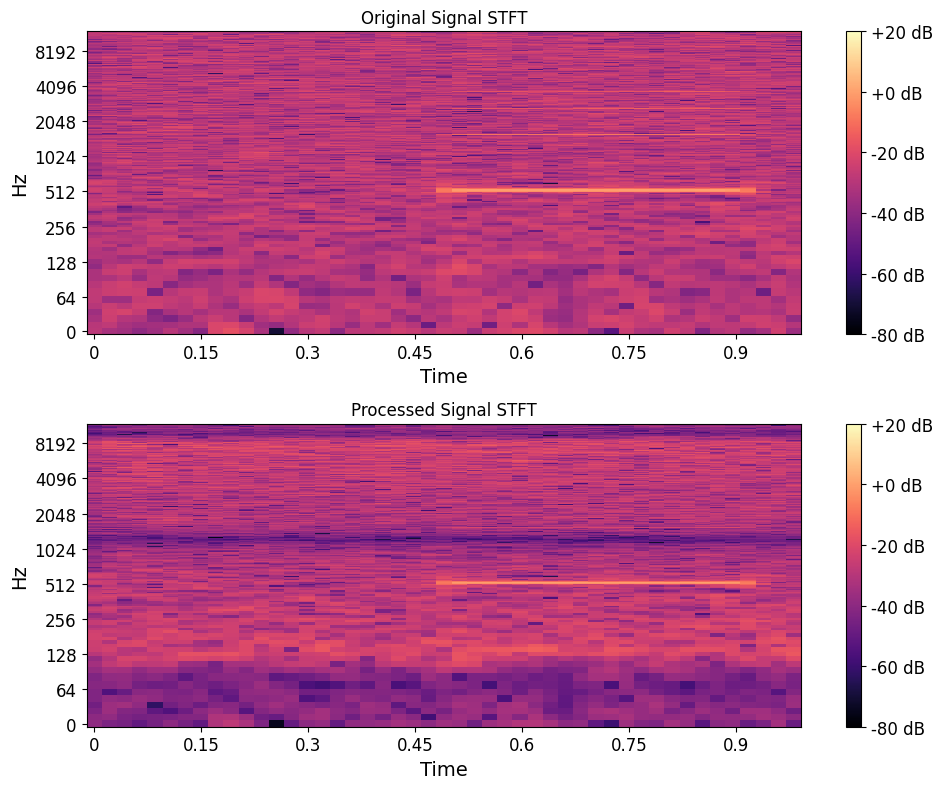

In [9]:
#PEQ Testing

t, original_signal = generate_signal()
params = np.random.uniform(-4, 4, 18)
processed_signal = apply_peq(original_signal, params)
visualize_signals_stft(original_signal, processed_signal)

Compressor

In [10]:
#DRC Implementation

#@jit(nopython=True)
def drc(
    x,
    sample_rate,
    params, #threshold, ratio, attack_time, release_time, knee_dB, makeup_gain_dB,
    eps=1e-8
):
    threshold = params[0] #-60 dB - 0 dB
    ratio = params[1] #1-10
    attack_time = params[2] #0.0001s - 0.1s
    release_time = params[3] #0.005s - 3s
    knee_dB = params[4] #0dB-24dB
    makeup_gain_dB = params[5] #0dB-20dB
    dtype=np.float32

    """print   (
                "+++DRC-Paramter+++"
                #"\nThreshold", tf.shape(params[0]),
                #"\nRatio", tf.shape(params[1]),
                #"\nAttack Time", tf.shape(params[2]),
                #"\nRelease Time", tf.shape(params[3]),
                #"\nKnee", tf.shape(params[4]),
                "\nSignal DRC", tf.shape(x), x,
                #"\nSignal 2", tf.shape(x[1]), x[1]
                )"""

    """Dynamic range compressor implemented in TensorFlow."""

    N = len(x)
    y = np.zeros(N, dtype=dtype)

    # Initialize separate attack and release times
    # Where do these numbers come from
    alpha_A = np.exp(-np.log(9) / (sample_rate * attack_time))
    alpha_R = np.exp(-np.log(9) / (sample_rate * release_time))

    # Turn the input signal into a uni-polar signal on the dB scale
    x_G = 20 * np.log10(np.abs(x) + 1e-8)  # x_uni casts type

    # Ensure there are no values of negative infinity
    #x_G = my_clip_min(x_G, -96)
    x_G = np.clip(x_G, -96, None)

    # Static characteristics with knee
    y_G = np.zeros(N, dtype=dtype)

    # Below knee
    idx = np.where((2 * (x_G - threshold)) < -knee_dB)[0]
    #y_G[idx] = x_G[idx]
    y_G[idx] = x_G[idx].flatten() 

    # At knee
    idx = np.where((2 * np.abs(x_G - threshold)) <= knee_dB)[0]
    y_G[idx] = x_G[idx].flatten() + (
        (1 / ratio) * (((x_G[idx].flatten() - threshold + knee_dB) / 2) ** 2)
    ) / (2 * knee_dB)

    # Above knee threshold
    idx = np.where((2 * (x_G - threshold)) > knee_dB)[0]
    y_G[idx] = threshold + ((x_G[idx].flatten() - threshold) / ratio)

    x_L = x_G.flatten() - y_G.flatten()


    # this loop is slow but not vectorizable due to its cumulative, sequential nature. @autojit makes it fast(er).
    y_L = np.zeros(N, dtype=dtype)

    for n in range(1, N):
        # smooth over the gainChange
        if x_L[n].all() > y_L[n - 1].all():  # attack mode
            y_L[n] = (alpha_A * y_L[n - 1]) + ((1 - alpha_A) * x_L[n])
        else:  # release
            y_L[n] = (alpha_R * y_L[n - 1]) + ((1 - alpha_R) * x_L[n])

    # Convert to linear amplitude scalar; i.e. map from dB to amplitude
    y_L = np.clip(y_L, -96, None)
    lin_y_L = np.power(10.0, (-y_L / 20.0))
    y = lin_y_L * x  # Apply linear amplitude to input sample

    y *= np.power(10.0, makeup_gain_dB / 20.0)  # apply makeup gain

    return y


In [11]:
# Apply Function for DRC

def apply_drc(x, drc_arg):

    """print("+++Apply Parameter+++")
    print("\n Sginal: ", tf.shape(x), x )"""

    threshold = 0-abs(drc_arg[0]*15) #-60 dB - 0 dB
    ratio = abs(drc_arg[1])*2.5
    attack_time = min(abs(drc_arg[2])/40,0.1) #0.0001s - 0.1s
    release_time = min(abs(drc_arg[3])/(3),3) #0.005s - 3s
    knee_dB = abs(drc_arg[4])*6 #0dB-24dB
    makeup_gain_dB = abs(drc_arg[5])*5 #0dB-20dB
    #dtype=np.float32

    drc_arg=np.array([
        threshold, ratio, attack_time, release_time, knee_dB, makeup_gain_dB
    ])

    tensor=False

    if(isinstance(x, tf.Tensor)):
        x = x.numpy().astype(np.float32)
        tensor=True


    output = drc(
        x = x,
        sample_rate = samples_per,
        params = drc_arg
    )

    if(tensor==True):
        output = tf.convert_to_tensor(output, dtype=tf.float32)

    if not np.isfinite(output).all():
                  output[np.isinf(output)] = 0
                  output[np.isnan(output)] = 0

    return output

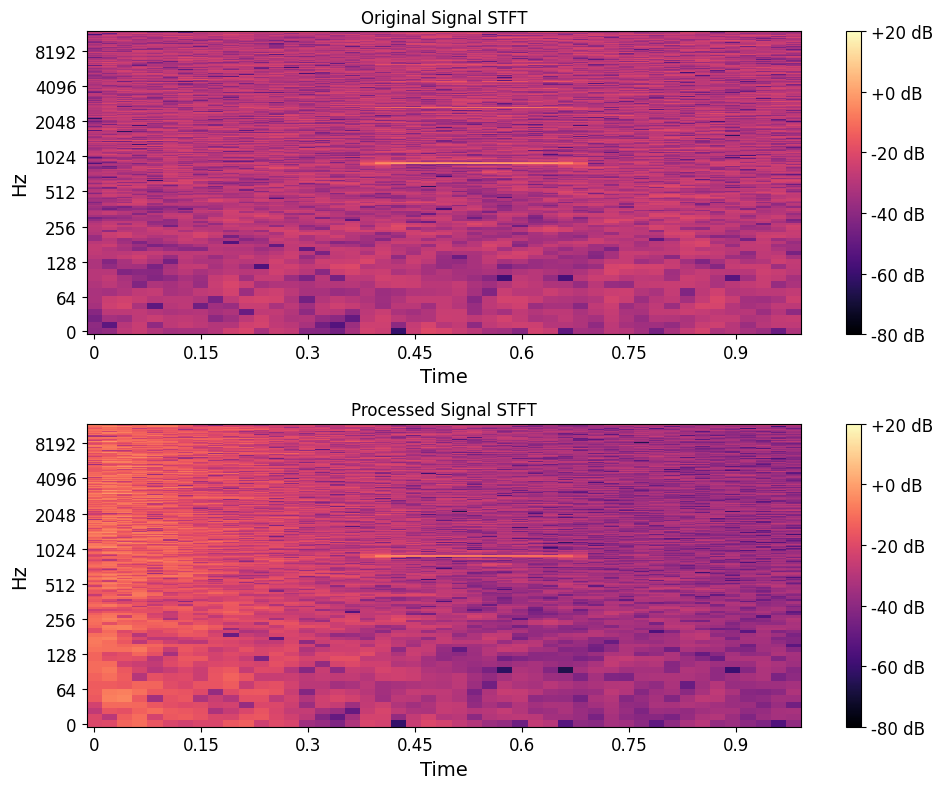

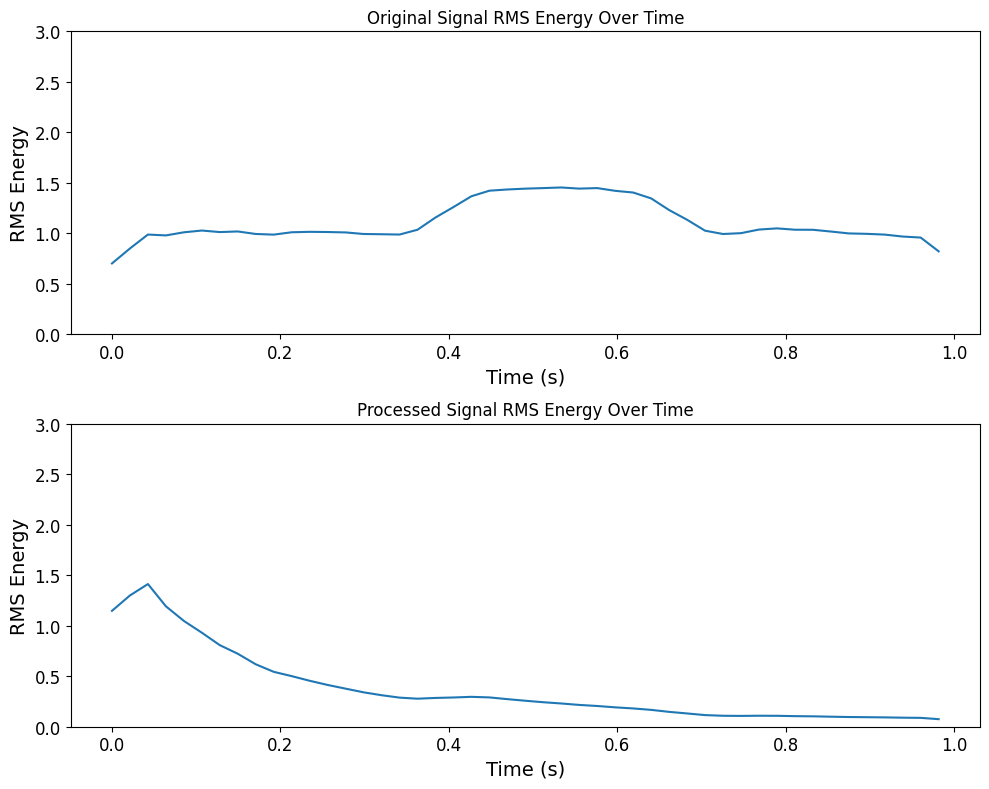

In [12]:
#Compressor Testing
np.random.seed(43)
t, original_signal = generate_signal()
params = np.random.uniform(-4, 4, 6)
processed_signal = apply_drc(original_signal, params)
visualize_signals_stft(original_signal, processed_signal)
visualize_signals_rms(original_signal, processed_signal)

SPSA-Layer

In [13]:
# SPSA for PEQ (https://github.com/adobe-research/DeepAFx/blob/main/scripts/custom_grad_example6.py)
tf.random.set_seed(0)
np.random.seed(0)

@tf.custom_gradient
def spsa_peq(x, y):

    epsilon = 0.005
    
    def _func(xe, ye):
        """Function applied to each element of the batch"""
        x=apply_peq(xe, ye)   

        return x

    def func(x, y):

        # Iterate over batch item
        z = []
        for i in range(x.shape[0]):
            z.append(_func(x[i], y[i]))
        z = tf.stack(z)
        return z

    def grad_fn(dy):
        """Gradient applied to each batch"""

        def _grad_fn(dye, xe, ye):
            """Gradient applied to each element of the batch"""

            # Grad w.r.t x. NOTE: this is approximate and should +-epsilon for each element
            J_plus = _func(xe + epsilon, ye)
            J_minus = _func(xe - epsilon, ye)
            gradx = (J_plus -  J_minus)/(2.0*epsilon)
            vecJxe = gradx * dye

            # Grad w.r.t y
            yc = ye.numpy()

            # pre-allocate vector * Jaccobian output
            vecJye = np.zeros_like(ye)

            # Iterate over each parameter and compute the output
            for i in range(ye.shape[0]):

                yc[i] = yc[i] + epsilon
                J_plus = _func(xe, yc)
                yc[i] = yc[i] - 2*epsilon
                J_minus = _func(xe, yc)
                grady = (J_plus -  J_minus)/(2.0*epsilon)
                yc[i] = yc[i] + 1*epsilon
                vecJye[i] = np.dot(np.transpose(dye), grady)

            return vecJxe, vecJye

        dy1 = []
        dy2 = []
        for i in range(dy.shape[0]):
            vecJxe, vecJye = _grad_fn(dy[i], x[i], y[i])
            dy1.append(vecJxe)
            dy2.append(vecJye)
        return tf.stack(dy1), tf.stack(dy2)

    return func(x, y), grad_fn


In [14]:
# SPSA for DRC (https://github.com/adobe-research/DeepAFx/blob/main/scripts/custom_grad_example6.py)

@tf.custom_gradient
def spsa_drc(x, y):

    epsilon = 0.005

    def _func(xe, ye):
        """Function applied to each element of the batch"""
        x=apply_drc(xe, ye)   
        return x

    def func(x, y):

        # Iterate over batch item
        z = []
        for i in range(x.shape[0]):
            z.append(_func(x[i], y[i]))
        z = tf.stack(z)
        return z

    def grad_fn(dy):
        """Gradient applied to each batch"""

        def _grad_fn(dye, xe, ye):
            """Gradient applied to each element of the batch"""

            # Grad w.r.t x. NOTE: this is approximate and should +-epsilon for each element
            J_plus = _func(xe + epsilon, ye)
            J_minus = _func(xe - epsilon, ye)
            gradx = (J_plus -  J_minus)/(2.0*epsilon)
            vecJxe = gradx * dye

            # Grad w.r.t y
            yc = ye.numpy()

            # pre-allocate vector * Jaccobian output
            vecJye = np.zeros_like(ye)

            # Iterate over each parameter and compute the output
            for i in range(ye.shape[0]):

                yc[i] = yc[i] + epsilon
                J_plus = _func(xe, yc)
                yc[i] = yc[i] - 2*epsilon
                J_minus = _func(xe, yc)
                grady = (J_plus -  J_minus)/(2.0*epsilon)
                yc[i] = yc[i] + 1*epsilon
                vecJye[i] = np.dot(np.transpose(dye), grady)

            return vecJxe, vecJye

        dy1 = []
        dy2 = []
        for i in range(dy.shape[0]):
            vecJxe, vecJye = _grad_fn(dy[i], x[i], y[i])
            dy1.append(vecJxe)
            dy2.append(vecJye)
        return tf.stack(dy1), tf.stack(dy2)

    return func(x, y), grad_fn

In [15]:
# Create a Keras Layer for PEQ 
class PEQLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PEQLayer, self).__init__()

    def build(self, input_shape):
        self.oshape = input_shape
        super(PEQLayer, self).build(input_shape)

    def call(self, inputs):
        x = inputs[0]
        params = inputs[1]

        ret = tf.py_function(func=spsa_peq,
                             inp=[x, params],
                             Tout=tf.float32)
        ret.set_shape(x.get_shape())

        return ret



In [16]:
# Create a Keras Layer for Compressor 
class DRCLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DRCLayer, self).__init__()

    def build(self, input_shape):
        self.oshape = input_shape
        super(DRCLayer, self).build(input_shape)

    def call(self, inputs):
        x = inputs[0]
        params = inputs[1]

        ret = tf.py_function(func=spsa_drc,
                             inp=[x, params],
                             Tout=tf.float32)
        ret.set_shape(x.get_shape())
        
        return ret

In [17]:
# Combined DSP Layer
class DSPLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DSPLayer, self).__init__()
        self.peq_layer = PEQLayer()
        self.drc_layer = DRCLayer()

    def build(self, input_shape):
    # Initialize the sub-layers
        self.oshape = input_shape
        self.peq_layer.build(input_shape)
        self.drc_layer.build(input_shape)
        super(DSPLayer, self).build(input_shape)

    def call(self, inputs):
        # Defining parameter for DSP
        signal, params = inputs
        peq_params, drc_params = tf.split(params, [18, 6], axis=1)
        """tf.print("params")
        tf.print(tf.shape(params))
        tf.print("peq_params")
        tf.print(tf.shape(peq_params))
        tf.print("drc_paramss")
        tf.print(tf.shape(drc_params))"""
        peq_output = self.peq_layer([signal, peq_params])
        """tf.print("signal")
        tf.print((signal))
        tf.print("peq_output")
        tf.print((peq_output))"""
        drc_output = self.drc_layer([peq_output, drc_params]) # Assuming params is unchanged. Modify if needed.
        return drc_output

Test-Netzwerk

In [18]:
#Mel-Layer
import tensorflow as tf
import numpy as np
import librosa

class MelSpectrogramLayer(tf.keras.layers.Layer):
    def __init__(self, sample_rate=24000, n_fft=256, hop_length=128, n_mels=128, target_shape=None, **kwargs):
        super().__init__(**kwargs)
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.target_shape = target_shape

    def call(self, audio, training=False):
        def _mel_spectrogram(waveform):
            # Convert to mono if the waveform is stereo
            if waveform.ndim == 2 and waveform.shape[1] == 2:
                waveform = np.mean(waveform, axis=1)

            # Compute Mel spectrogram
            S = librosa.feature.melspectrogram(y=waveform, sr=self.sample_rate,
                                               n_fft=self.n_fft, hop_length=self.hop_length,
                                               n_mels=self.n_mels)
            return S.astype(np.float32)

        # Apply _mel_spectrogram using tf.numpy_function
        mel_spectrograms = tf.numpy_function(_mel_spectrogram, [audio], tf.float32)

        # Set shape to the Mel spectrograms
        mel_spectrograms.set_shape((None, self.n_mels, None))

        # Add a channel dimension
        mel_spectrograms = tf.expand_dims(mel_spectrograms, -1)

        # Resize if target shape is provided
        if self.target_shape is not None:
            mel_spectrograms = tf.image.resize(mel_spectrograms, self.target_shape)

        return mel_spectrograms
    

In [19]:
#Multi-Resolutional STFT Loss
#Orientiert an https://github.com/TensorSpeech/TensorflowTTS/blob/master/tensorflow_tts/losses/stft.py

class TFSpectralConvergence(tf.keras.layers.Layer):
    """Spectral convergence loss."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.norm(y_mag - x_mag, ord="fro", axis=(-2, -1)) / tf.norm(
            y_mag, ord="fro", axis=(-2, -1)
        )


class TFLogSTFTMagnitude(tf.keras.layers.Layer):
    """Log STFT magnitude loss module."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y_mag, x_mag):
        """Calculate forward propagation.
        Args:
            y_mag (Tensor): Magnitude spectrogram of groundtruth signal (B, #frames, #freq_bins).
            x_mag (Tensor): Magnitude spectrogram of predicted signal (B, #frames, #freq_bins).
        Returns:
            Tensor: Spectral convergence loss value.
        """
        return tf.abs(tf.math.log(y_mag) - tf.math.log(x_mag))


class TFSTFT(tf.keras.layers.Layer):
    """STFT loss module."""

    def __init__(self, frame_length=600, frame_step=120, fft_length=1024):
        """Initialize."""
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.spectral_convergenge_loss = TFSpectralConvergence()
        self.log_stft_magnitude_loss = TFLogSTFTMagnitude()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Spectral convergence loss value (pre-reduce).
            Tensor: Log STFT magnitude loss value (pre-reduce).
        """
        x_mag = tf.abs(
            tf.signal.stft(
                signals=x,
                frame_length=self.frame_length,
                frame_step=self.frame_step,
                fft_length=self.fft_length,
            )
        )
        y_mag = tf.abs(
            tf.signal.stft(
                signals=y,
                frame_length=self.frame_length,
                frame_step=self.frame_step,
                fft_length=self.fft_length,
            )
        )

        # add small number to prevent nan value.
        # compatible with pytorch version.
        x_mag = tf.clip_by_value(tf.math.sqrt(x_mag ** 2 + 1e-7), 1e-7, 1e3)
        y_mag = tf.clip_by_value(tf.math.sqrt(y_mag ** 2 + 1e-7), 1e-7, 1e3)

        sc_loss = self.spectral_convergenge_loss(y_mag, x_mag)
        mag_loss = self.log_stft_magnitude_loss(y_mag, x_mag)

        return sc_loss, mag_loss
    
class TFMultiResolutionSTFT(tf.keras.layers.Layer):
    """Multi resolution STFT loss module."""

    def __init__(
        self,
        fft_lengths=[1024, 2048, 512],
        frame_lengths=[600, 1200, 240],
        frame_steps=[120, 240, 50],
    ):
        """Initialize Multi resolution STFT loss module.
        Args:
            frame_lengths (list): List of FFT sizes.
            frame_steps (list): List of hop sizes.
            fft_lengths (list): List of window lengths.
        """
        super().__init__()
        assert len(frame_lengths) == len(frame_steps) == len(fft_lengths)
        self.stft_losses = []
        for frame_length, frame_step, fft_length in zip(
            frame_lengths, frame_steps, fft_lengths
        ):
            self.stft_losses.append(TFSTFT(frame_length, frame_step, fft_length))

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Multi resolution spectral convergence loss value.
            Tensor: Multi resolution log STFT magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for f in self.stft_losses:
            sc_l, mag_l = f(y, x)
            sc_loss += tf.reduce_mean(sc_l, axis=list(range(1, len(sc_l.shape))))
            mag_loss += tf.reduce_mean(mag_l, axis=list(range(1, len(mag_l.shape))))

        sc_loss /= len(self.stft_losses)
        mag_loss /= len(self.stft_losses)

        return sc_loss, mag_loss
    


In [20]:
#Multi-Resolutional Mel Loss
#Orientiert an https://github.com/TensorSpeech/TensorflowTTS/blob/master/tensorflow_tts/losses/stft.py


class TFMelSpectralConvergence(tf.keras.layers.Layer):
    """Mel spectral convergence loss."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Magnitude mel spectrogram of groundtruth signal (B, #frames, #mel_bins).
            x (Tensor): Magnitude mel spectrogram of predicted signal (B, #frames, #mel_bins).
        Returns:
            Tensor: Mel spectral convergence loss value.
        """
        return tf.norm(y - x, ord="fro", axis=(-2, -1)) / tf.norm(y, ord="fro", axis=(-2, -1))


class TFLogMelMagnitude(tf.keras.layers.Layer):
    """Log mel magnitude loss module."""

    def __init__(self):
        """Initialize."""
        super().__init__()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Magnitude mel spectrogram of groundtruth signal (B, #frames, #mel_bins).
            x (Tensor): Magnitude mel spectrogram of predicted signal (B, #frames, #mel_bins).
        Returns:
            Tensor: Log mel magnitude loss value.
        """
        return tf.abs(tf.math.log(y + 1e-7) - tf.math.log(x + 1e-7))
    


class TFMelSTFT(tf.keras.layers.Layer):
    """Mel STFT loss module."""

    def __init__(self, num_mel_bins=128, sample_rate=24000, fmin=20, fmax=12000,
                 frame_length=2048, frame_step=512, fft_length=2048):
        """Initialize."""
        super().__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.num_mel_bins = num_mel_bins
        self.sample_rate = sample_rate
        self.fmin = fmin
        self.fmax = fmax
        self.spectral_convergenge_loss = TFMelSpectralConvergence()
        self.log_mel_magnitude_loss = TFLogMelMagnitude()

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Mel spectral convergence loss value (pre-reduce).
            Tensor: Log mel magnitude loss value (pre-reduce).
        """
        # Compute STFT
        y_stft = tf.signal.stft(signals=y, frame_length=self.frame_length, frame_step=self.frame_step, fft_length=self.fft_length)
        x_stft = tf.signal.stft(signals=x, frame_length=self.frame_length, frame_step=self.frame_step, fft_length=self.fft_length)

        # Convert to magnitude
        y_mag = tf.abs(y_stft)
        x_mag = tf.abs(x_stft)

        # Compute mel spectrograms
        mel_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=self.num_mel_bins, num_spectrogram_bins=self.fft_length // 2 + 1, sample_rate=self.sample_rate, lower_edge_hertz=self.fmin, upper_edge_hertz=self.fmax)
        y_mel = tf.tensordot(y_mag, mel_matrix, 1)
        x_mel = tf.tensordot(x_mag, mel_matrix, 1)

        # Normalize for numerical stability
        y_mel = tf.clip_by_value(tf.math.sqrt(y_mel ** 2 + 1e-7), 1e-7, 1e3)
        x_mel = tf.clip_by_value(tf.math.sqrt(x_mel ** 2 + 1e-7), 1e-7, 1e3)

        # Calculate losses
        sc_loss = self.spectral_convergenge_loss(y_mel, x_mel)
        mag_loss = self.log_mel_magnitude_loss(y_mel, x_mel)

        return sc_loss, mag_loss

class TFMultiResolutionMel(tf.keras.layers.Layer):
    """Multi resolution Mel spectrogram loss module."""

    def __init__(
        self,
        num_mel_bins=128,
        sample_rate=24000,
        fmin=20,
        fmax=12000,
        fft_lengths=[1024, 2048, 512],
        frame_lengths=[600, 1200, 240],
        frame_steps=[120, 240, 50],
    ):
        """Initialize Multi resolution Mel spectrogram loss module.
        Args:
            num_mel_bins (int): Number of Mel bins.
            sample_rate (int): Sample rate of the audio signal.
            fmin (float): Minimum frequency to include in the Mel scale.
            fmax (float): Maximum frequency to include in the Mel scale.
            frame_lengths (list): List of frame lengths.
            frame_steps (list): List of hop sizes.
            fft_lengths (list): List of FFT sizes.
        """
        super().__init__()
        assert len(frame_lengths) == len(frame_steps) == len(fft_lengths)
        self.mel_losses = []
        for frame_length, frame_step, fft_length in zip(frame_lengths, frame_steps, fft_lengths):
            self.mel_losses.append(
                TFMelSTFT(num_mel_bins=num_mel_bins, sample_rate=sample_rate, fmin=fmin, fmax=fmax,
                          frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
            )

    def call(self, y, x):
        """Calculate forward propagation.
        Args:
            y (Tensor): Groundtruth signal (B, T).
            x (Tensor): Predicted signal (B, T).
        Returns:
            Tensor: Multi resolution Mel spectral convergence loss value.
            Tensor: Multi resolution log Mel magnitude loss value.
        """
        sc_loss = 0.0
        mag_loss = 0.0
        for mel_loss in self.mel_losses:
            sc_l, mag_l = mel_loss(y, x)
            sc_loss += tf.reduce_mean(sc_l, axis=list(range(1, len(sc_l.shape))))
            mag_loss += tf.reduce_mean(mag_l, axis=list(range(1, len(mag_l.shape))))

        sc_loss /= len(self.mel_losses)
        mag_loss /= len(self.mel_losses)

        return sc_loss, mag_loss
    

In [21]:
# Building Test-Model

def get_model(time_samples):

    num_params = 18#24
    num_basis = 32

    audio_time = keras.layers.Input(shape=(time_samples,1), name='audio_time')

    x = tf.keras.layers.Dense(num_basis, activation='linear')(audio_time)
    x = keras.layers.Reshape((time_samples,num_basis,1))(x)
    x = keras.layers.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)

    x = tf.keras.backend.mean(x, axis=1, keepdims=False)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(.1)(x)
    hidden1 = tf.keras.layers.Dense(num_params, activation='linear')(x)
    clipped_params = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, clip_value_min=-4, clip_value_max=4))(hidden1)


    # Build analyzer model for params retrieve
    analyzer_model = tf.keras.models.Model(inputs=[audio_time], 
                                           outputs=[clipped_params], 
                                           name="analyzer_model")
    hidden_params = analyzer_model(audio_time)

    #dafx_output = DRCLayer()([audio_time, hidden_params])
    dafx_output = PEQLayer()([audio_time, hidden_params])
    #dafx_output = DSPLayer()([audio_time, hidden_params])

    flat = keras.layers.Flatten()(dafx_output)

    # Compute the model
    full_model = keras.models.Model(inputs=[audio_time], outputs=flat, name="full_model")

    return full_model, analyzer_model

def db(x):
    return 20*np.log10(np.sqrt(np.mean(np.square(x))))

def get_data():

    # Synthesize random audio signals with random filters, predict unfiltered signal
    signals = np.random.randn(num_samples, samples_per)
    x_train = signals.copy()

    y_train = 10*signals.copy()

    for i in range(signals.shape[0]):
        #gain_dB = np.random.rand(1)[0]*40 - 20
        #gain_linear = 10**((gain_dB)/20)

        low_shelf_gain_dB = (np.random.rand(1)[0] * 48) - 24
        low_shelf_cutoff_freq = min(((np.random.rand(1)[0]*4)*10)+80, 11000)
        low_shelf_q_factor = abs((np.random.rand(1)[0]*4))*2+0.707
        
        first_band_gain_dB=(np.random.rand(1)[0] * 48) - 24
        first_band_cutoff_freq=min(((np.random.rand(1)[0]*4)*24)+300, 11000)
        first_band_q_factor=abs((np.random.rand(1)[0]*4))*2+0.707

        second_band_gain_dB=(np.random.rand(1)[0] * 48) - 24
        second_band_cutoff_freq=min(((np.random.rand(1)[0]*4)*125)+1000, 11000)
        second_band_q_factor=abs((np.random.rand(1)[0]*4))*2+0.707

        third_band_gain_dB=(np.random.rand(1)[0] * 48) - 24
        third_band_cutoff_freq=min(((np.random.rand(1)[0]*4)*250)+2000, 11000)
        third_band_q_factor=abs((np.random.rand(1)[0]*4))*2+0.707

        fourth_band_gain_dB=(np.random.rand(1)[0] * 48) - 24
        fourth_band_cutoff_freq=min(((np.random.rand(1)[0]*4)*500)+4000, 11000)
        fourth_band_q_factor=abs((np.random.rand(1)[0]*4))*2+0.707
        
        high_shelf_gain_dB=(np.random.rand(1)[0] * 48) - 24
        high_shelf_cutoff_freq = min(((np.random.rand(1)[0]*4)*1000)+8000, 12000)
        high_shelf_q_factor=abs((np.random.rand(1)[0]*4))*2+0.707

        peq_arg =   [low_shelf_gain_dB, low_shelf_cutoff_freq, low_shelf_q_factor,
                    first_band_gain_dB, first_band_cutoff_freq, first_band_q_factor,
                    second_band_gain_dB, second_band_cutoff_freq, second_band_q_factor,        
                    third_band_gain_dB, third_band_cutoff_freq, third_band_q_factor,
                    fourth_band_gain_dB, fourth_band_cutoff_freq, fourth_band_q_factor,
                    high_shelf_gain_dB, high_shelf_cutoff_freq, high_shelf_q_factor]

        temp = x_train[i,:]/np.sqrt(np.mean(np.square(x_train[i,:]))) #Normalizing Signal
        
        x_train[i,:] = parametric_eq(x = temp, sample_rate=samples_per, params=peq_arg)

        threshold = -abs((np.random.rand(1)[0]*4)*15) #-60 dB - 0 dB
        ratio = abs((np.random.rand(1)[0]*4))*2.5 #1-10
        attack_time = min((np.random.rand(1)[0]*4)/40,0.1) #0.0001s - 0.1s
        release_time = min(abs((np.random.rand(1)[0]*4))/(3),3) #0.005s - 3s
        knee_dB = abs((np.random.rand(1)[0]*4))*6 #0dB-24dB
        makeup_gain_dB = abs((np.random.rand(1)[0]*4))*5 #0dB-20dB

        drc_arg = [float(threshold), float(ratio), float(attack_time), float(release_time), float(knee_dB), float(makeup_gain_dB)]

        if(i<4):
            print   (
                "+++PEQ+++"
                "\nLowCut", peq_arg[0], peq_arg[1], peq_arg[2], 
                "\nFirstBand", peq_arg[3], peq_arg[4], peq_arg[5], 
                "\nSecondBand", peq_arg[6], peq_arg[7], peq_arg[8], 
                "\nThirdBand", peq_arg[9], peq_arg[10], peq_arg[11], 
                "\nFourthBand", peq_arg[12], peq_arg[13], peq_arg[14], 
                "\nHighCut", peq_arg[15], peq_arg[16], peq_arg[17], 
                )

            print   (
                "+++DRC+++"
                "\nThreshold", drc_arg[0],
                "\nRatio", drc_arg[1],
                "\nAttack Time", drc_arg[2],
                "\nRelease Time",drc_arg[3],
                "\nKnee", drc_arg[4],
                "\nMakeUp", drc_arg[5],
                )


        x_train[i,:] = drc(x = x_train[i,:], sample_rate=samples_per, params=drc_arg)

        y_train[i,:] = temp


    return x_train, y_train

In [22]:
# Create the model
model, analyzer_model = get_model(samples_per)

model.summary()
analyzer_model.summary()

# Synthesize data
x_train, y_train = get_data()

Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 audio_time (InputLayer)     [(None, 24000, 1)]           0         []                            
                                                                                                  
 analyzer_model (Functional  (None, 18)                   47570     ['audio_time[0][0]']          
 )                                                                                                
                                                                                                  
 peq_layer (PEQLayer)        (None, 24000, 1)             0         ['audio_time[0][0]',          
                                                                     'analyzer_model[0][0]']      
                                                                                         

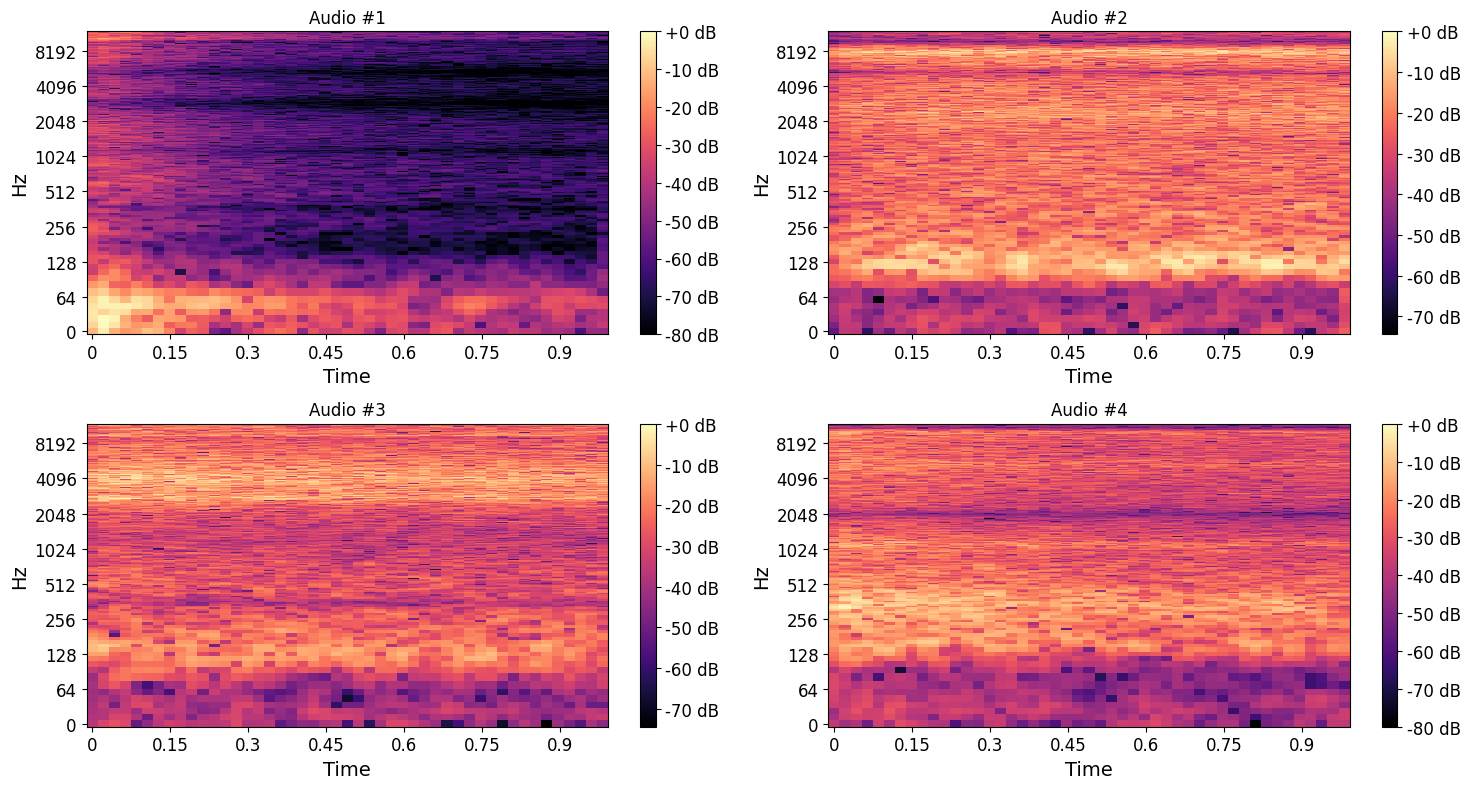

In [23]:
# Inspecting Training Model Spectral Variance

audio_data_array = x_train
num_plots = min(len(audio_data_array), 4)

sr=samples_per
n_fft=2048
hop_length=512
n_mels=128

# Set up the matplotlib figure with subplots
fig, axs = plt.subplots((num_plots + 1) // 2, 2, figsize=(15, 2 * num_plots))
if num_plots < 2:
    axs = np.array([axs])
axs = axs.flatten()

for i in range(num_plots):
    y = audio_data_array[i]
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=axs[i])
    axs[i].set_title(f'Audio #{i+1}')
    fig.colorbar(img, ax=axs[i], format='%+2.0f dB')



# Adjust layout
plt.tight_layout()
plt.show()

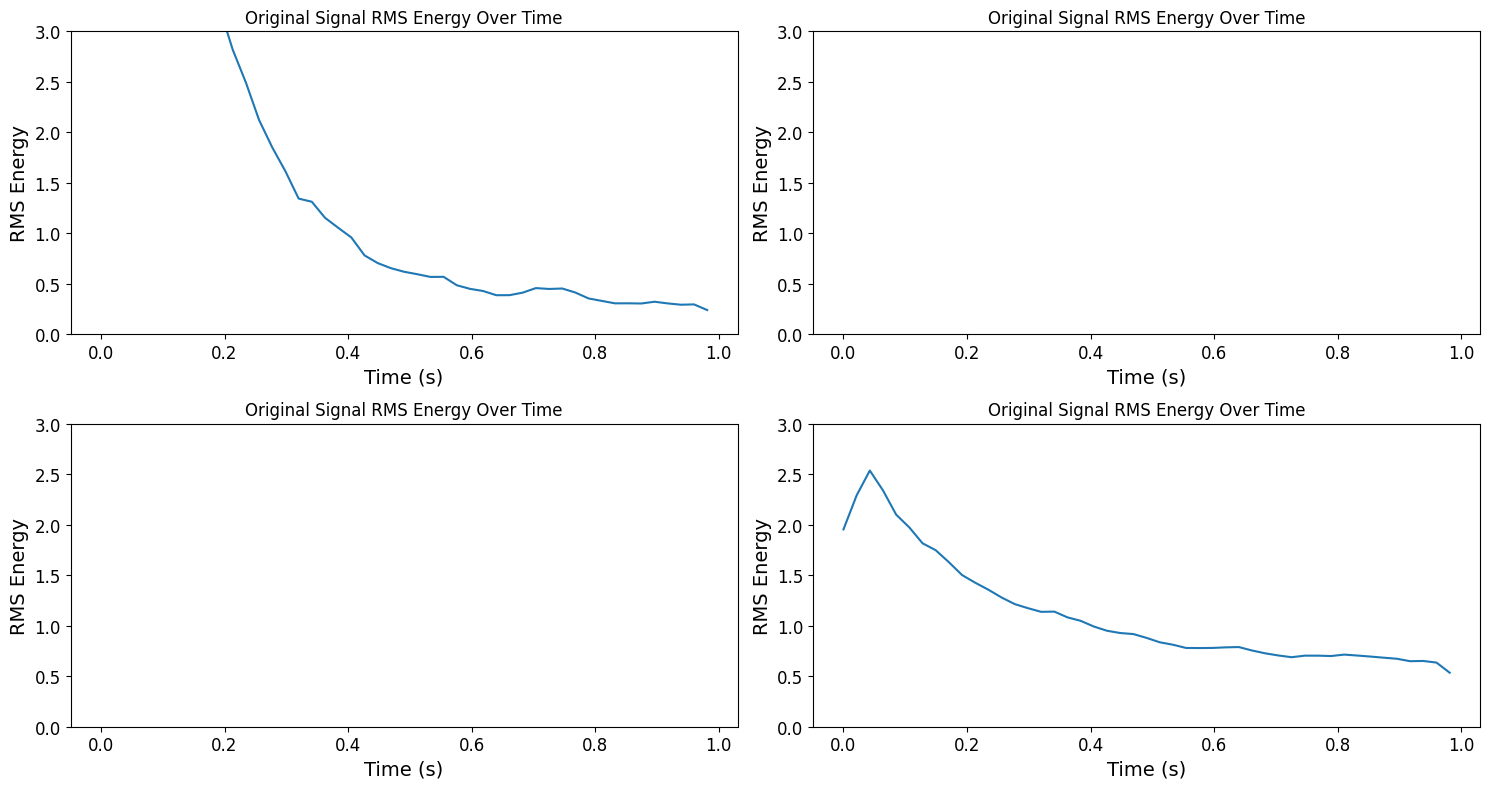

In [24]:
# Inspecting Training Model RMS Variance

audio_data_array = x_train
num_plots = min(len(audio_data_array), 4)

sr=samples_per
n_fft=2048
hop_length=512
n_mels=128

# Set up the matplotlib figure with subplots
fig, axs = plt.subplots((num_plots + 1) // 2, 2, figsize=(15, 2 * num_plots))
if num_plots < 2:
    axs = np.array([axs])
axs = axs.flatten()

for i in range(num_plots):

    y = audio_data_array[i]
    rms_original = librosa.feature.rms(y=y)[0]
    times_original = librosa.times_like(rms_original, sr=sr)
    axs[i].plot(times_original, rms_original)
    axs[i].set(title='Original Signal RMS Energy Over Time')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('RMS Energy')
    axs[i].set_ylim(0,3)

# Adjust layout
plt.tight_layout()
plt.show()

In [25]:
#Train!

es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min',
        baseline=None, restore_best_weights=True)

#opt = keras.optimizers.legacy.SGD(learning_rate=0.001) => Doesn't work really well on the examples
opt = keras.optimizers.legacy.Adam(learning_rate=0.01)
#opt = keras.optimizers.Adam(learning_rate=0.01)

#Instantiate the MR-Loss Classes
TF_MR_STFT = TFMultiResolutionSTFT()
TF_MR_MEL = TFMultiResolutionMel()

#model.compile(optimizer=opt,loss=lambda y_true, y_pred: tf.reduce_mean(TF_MR_STFT(y_true, y_pred)[0] + TF_MR_MEL(y_true, y_pred)[1])) #Begins with lower loss, finer steps
model.compile(optimizer=opt,loss=lambda y_true, y_pred: tf.reduce_mean(TF_MR_STFT(y_true, y_pred)[0] + TF_MR_STFT(y_true, y_pred)[1])) #Begins with lower loss, finer steps
#model.compile(optimizer=opt,loss='mean_squared_error')

model.fit(x_train, y_train,
          epochs=2,
          validation_split=0.2,
          batch_size=30,
          shuffle=True,
          verbose=True,
          callbacks=[es])

Epoch 1/2


/var/folders/ns/5jwx24fs63l6_1bnl5jdcm5m0000gn/T/ipykernel_8885/4230994918.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vecJye[i] = np.dot(np.transpose(dye), grady)


2/2 [==============================] - 22s 3s/step - loss: 9.1209 - val_loss: 7.2467
Epoch 2/2
2/2 [==============================] - 20s 3s/step - loss: 8.8682 - val_loss: 7.1604


2/2 [==============================] - 2s 614ms/step
[-0.00707362 -0.19543336  0.01548615  0.09769487 -0.05323878  0.10149524
  0.12078444 -0.10999236 -0.01566284  0.07514614 -0.170142   -0.18650839
 -0.12352529  0.07438749  0.13003941  0.07856134 -0.05393404  0.07892857]
LowCut -0.04244169406592846 78.04566636681557 0.7379723075479269 FirstBand 0.5861691981554031 298.72226920723915 0.9099904872179031 SecondBand 0.7247066348791122 986.2509556114674 0.7383256792724132 ThirdBand 0.4508768320083618 1957.4645012617111 1.0800167746543883 FourthBand -0.741151750087738 4037.1937453746796 0.9670788176059723 HighCut 0.47136805951595306 7946.065958589315 0.86485713493824
[ 0.05677107 -0.7340025   0.05417248  0.38062134 -0.2022743   0.4853589
  0.5553284  -0.49878266 -0.01827806  0.324822   -0.7786878  -0.69564307
 -0.5402333   0.39568982  0.5520537   0.35598502 -0.24080476  0.36401924]
LowCut 0.34062644094228745 72.65997529029846 0.8153449572324752 FirstBand 2.283728063106537 295.14541697502136 

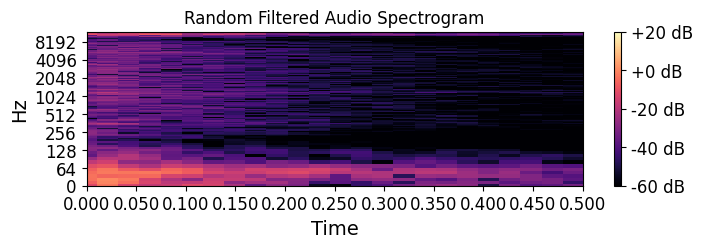

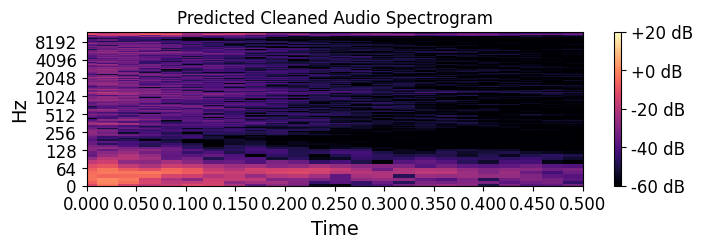

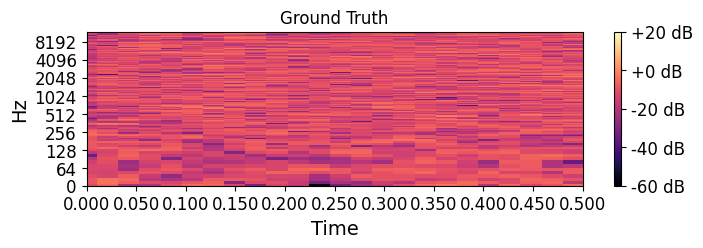

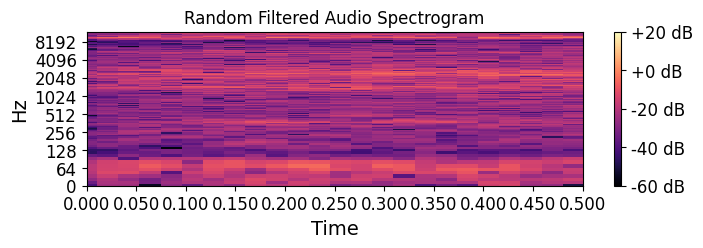

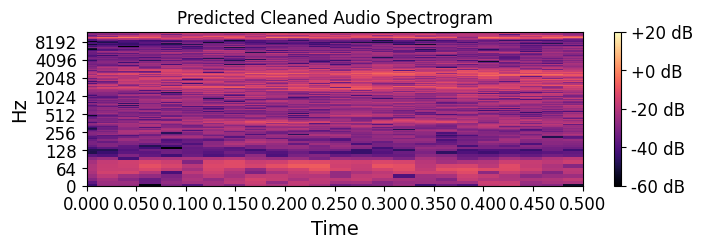

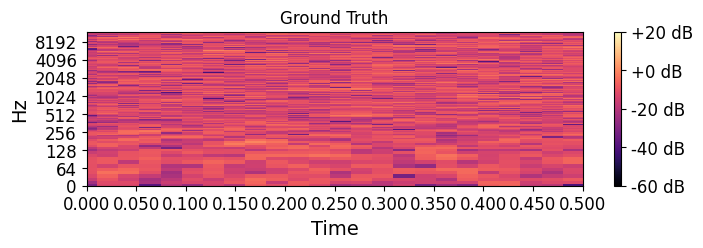

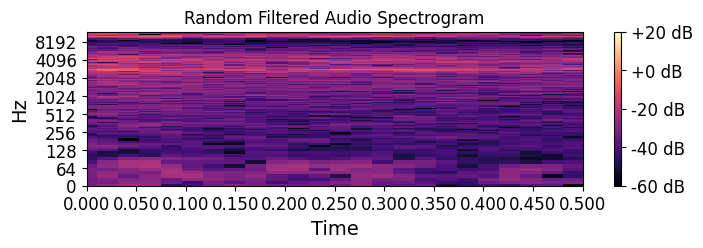

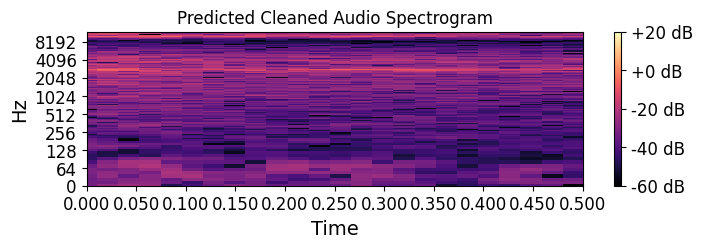

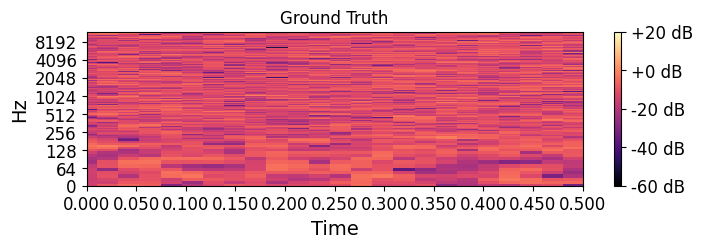

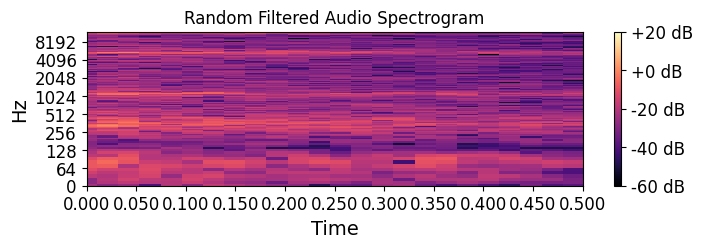

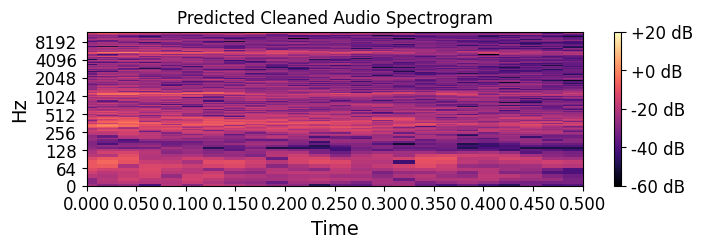

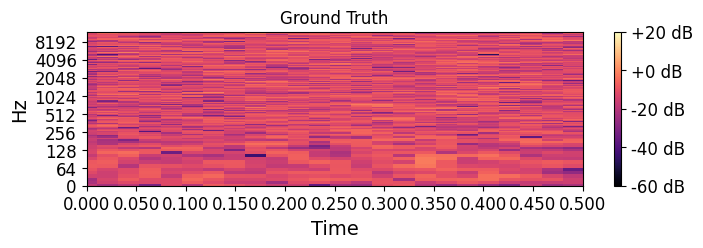

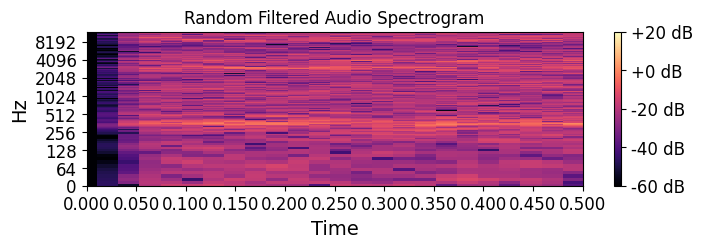

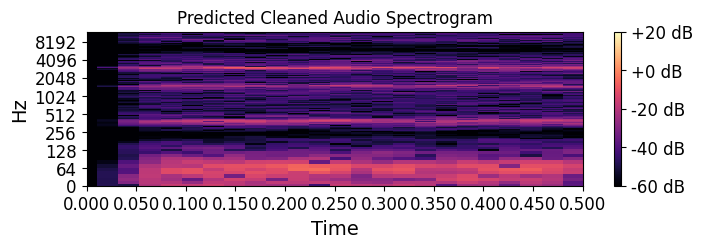

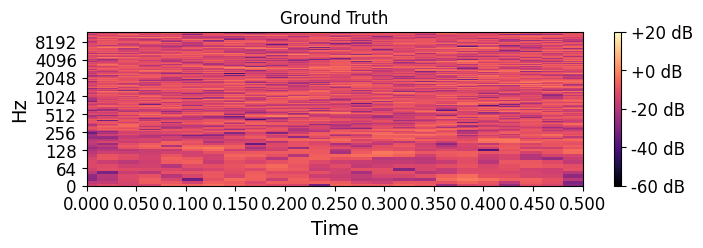

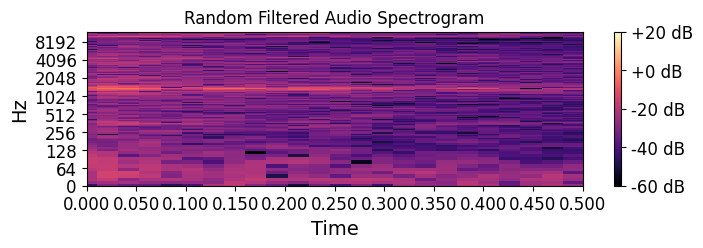

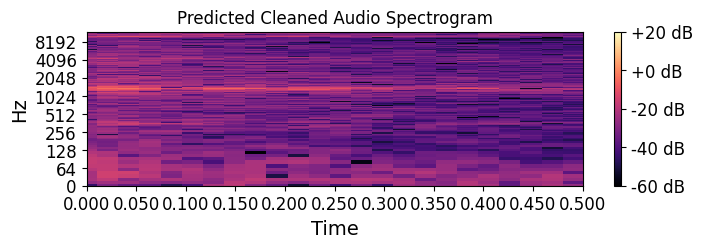

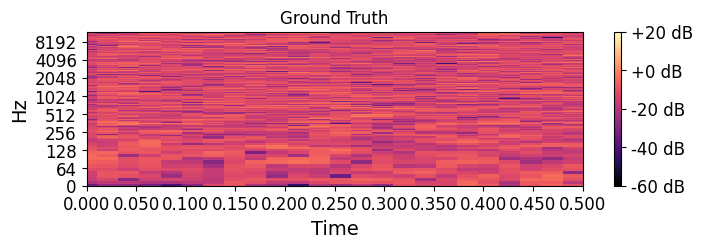

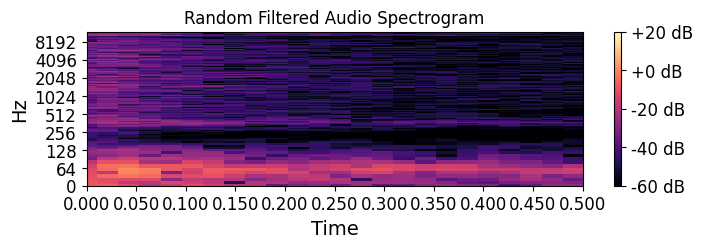

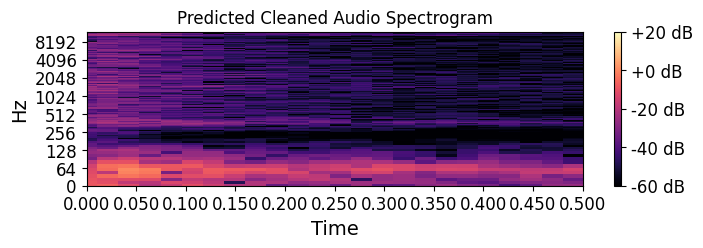

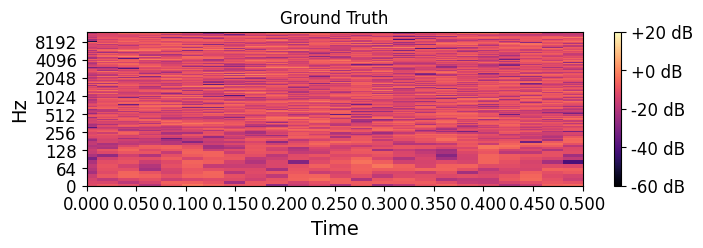

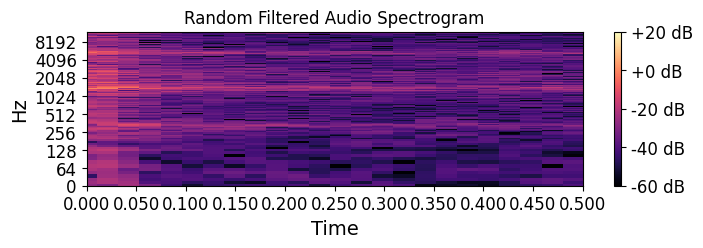

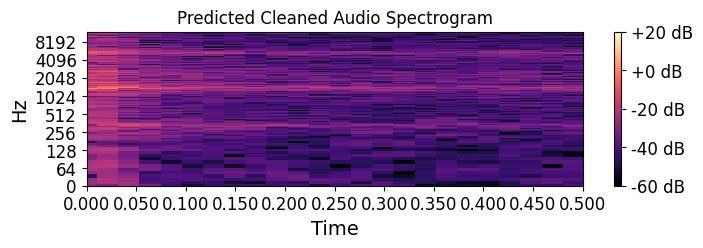

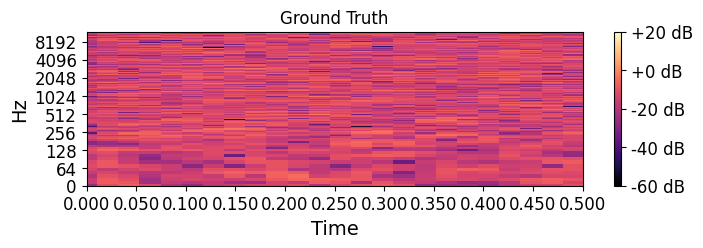

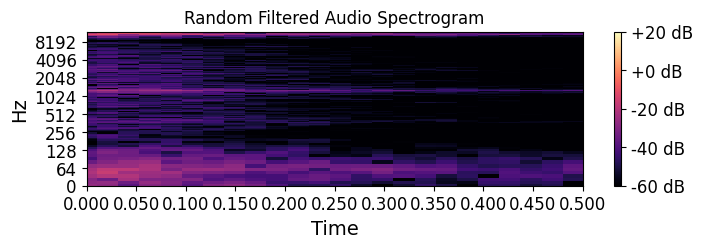

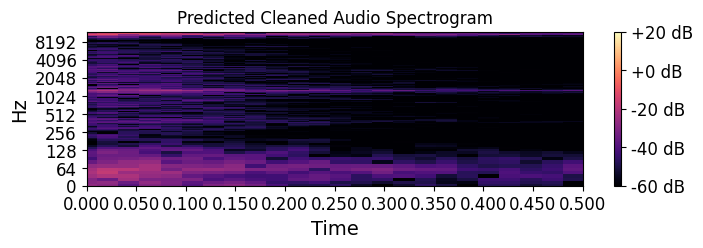

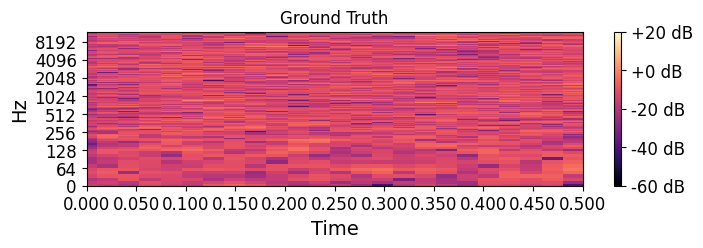

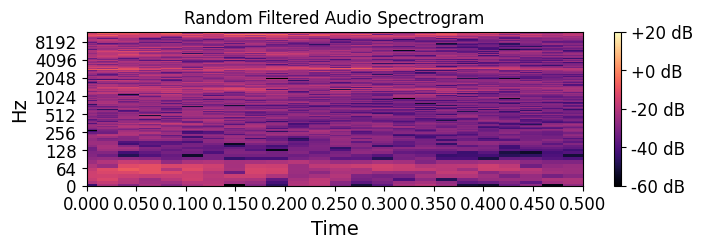

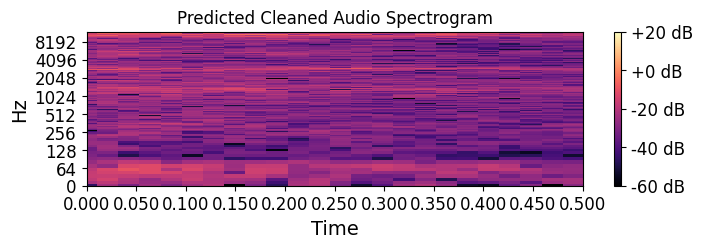

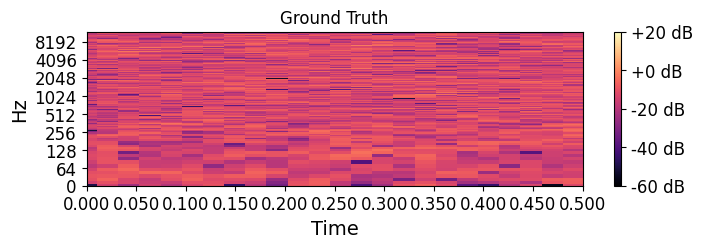

In [25]:
# Test a few predict examples
y_pred = model.predict(x_train)
sr=samples_per
y_pred_param = analyzer_model.predict(x_train)

for i in range(10):
    print(y_pred_param[i])
    peq_arg = y_pred_param[i]


    y_pred[i]=apply_peq(
            x=x_train[i],
            peq_arg = peq_arg,
    )
    
    print   (
            "LowCut", min(peq_arg[0]*6, 24), min((peq_arg[1]*10)+80, 11000), abs(peq_arg[2])*2+0.707, 
            "FirstBand", min(peq_arg[3]*6, 24), min((peq_arg[4]*24)+300, 11000), abs(peq_arg[5])*2+0.707, 
            "SecondBand", min(peq_arg[6]*6, 24), min((peq_arg[7]*125)+1000, 11000), abs(peq_arg[8])*2+0.707, 
            "ThirdBand", min(peq_arg[9]*6, 24), min((peq_arg[10]*250)+2000, 11000), abs(peq_arg[11])*2+0.707, 
            "FourthBand", min(peq_arg[12]*6, 24), min((peq_arg[13]*500)+4000, 11000), abs(peq_arg[14])*2+0.707, 
            "HighCut", min(peq_arg[15]*6, 24), min((peq_arg[16]*1000)+8000, 12000), abs(peq_arg[17])*2+0.707
            )


for i in range(10):
    #print('x_train, y_pred, y_truth', spectral_centriod(x_train[i,:]), spectral_centriod(y_pred[i,:]), spectral_centriod(y_train[i,:]))
    #print('DB: x_train, y_pred, y_truth', db(x_train[i,:]), db(y_pred[i,:]), db(y_train[i,:]) )
    #print('PESQ: x_train, y_pred, y_truth', pesq(samples_per, x_train[i,:]), pesq(samples_per, y_pred[i,:]), pesq(samples_per, y_train[i,:]) )


    # Plot the randomly eq'ed audio waveform
    plt.figure(figsize=(8, 2))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(x_train[i,:])), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', vmin=-60, vmax=20)
    plt.colorbar(format='%+2.0f dB')
    plt.xlim([0,0.5])
    plt.ylim([0, sr / 2])
    plt.title('Random Filtered Audio Spectrogram')
    plt.show()
    #Audio(y, rate=sr)

    # Plot the predicted cleaned audio waveform
    plt.figure(figsize=(8, 2))
    D_eq = librosa.amplitude_to_db(np.abs(librosa.stft(y_pred[i,:])), ref=np.max)
    librosa.display.specshow(D_eq, sr=sr, x_axis='time', y_axis='log', vmin=-60, vmax=20)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Predicted Cleaned Audio Spectrogram')
    plt.xlim([0,0.5])
    plt.ylim([0, sr / 2])
    plt.show()
    #Audio(eq_y, rate=sr)

    # Plot the Ground Truth
    plt.figure(figsize=(8, 2))
    D_truth = librosa.amplitude_to_db(np.abs(librosa.stft(y_train[i,:])), ref=np.max)
    librosa.display.specshow(D_truth, sr=sr, x_axis='time', y_axis='log', vmin=-60, vmax=20)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Ground Truth')
    plt.xlim([0,0.5])
    plt.ylim([0, sr / 2])
    plt.show()
    #Audio(eq_y, rate=sr)


if False:

    with tf.GradientTape(persistent=True) as tape:

        a = 2*np.ones((2,5,1)) # signal, shape = batch x time x 1
        b = 3*np.ones((2,1,1)) #b[0,1:2,0] = 1 # params, shape = batch x params x 1
        x = tf.constant(a, dtype=tf.float64)
        y = tf.constant(b, dtype=tf.float64)
        tape.watch(x)
        tape.watch(y)

        z4 = foo_custom_grad_numeric_batch(x, y)**2
        z1a = tf.py_function(func=foo_custom_grad_numeric_batch, inp=[x, y], Tout=tf.float32)**2
        z1b = tf.py_function(func=foo_custom_grad_numeric_batch, inp=[x, y], Tout=tf.float32)**2


    print('\n')
    print('Grad w.r.t. x')
    print("foo_custom_grad_numeric", tape.gradient(z4, x))
    print("py_function", tape.gradient(z1a, x))

    print('\n')
    print('Grad w.r.t. y')
    print("foo_custom_grad_numeric", tape.gradient(z4, y))
    print("py_function", tape.gradient(z1b, y))



In [105]:
#Try Real World Data

def load_and_resample(file_path, target_sr=24000):
    y, sr = librosa.load(file_path, sr=target_sr)
    y_first_second = y[:target_sr]
    
    return y_first_second

file_path = '/Users/farcy/Desktop/arne_export/BlaueStunde_Instrumental.wav'  # Specify the path to your WAV file
test_data = load_and_resample(file_path)
print(test_data)

y_pred = model.predict([test_data])
sr=samples_per
y_pred_param = analyzer_model.predict([test_data])

peq_arg = y_pred_param


y_pred=apply_peq(
        x=y_pred[0],
        low_shelf_gain_dB = (peq_arg[0]*6),
        low_shelf_cutoff_freq = min(abs(peq_arg[1]*15)+80, 11000),
        low_shelf_q_factor = abs(peq_arg[2])+0.707,
        first_band_gain_dB = (peq_arg[3]*6),
        first_band_cutoff_freq = min(abs(peq_arg[4]*24)+300, 11000),
        first_band_q_factor = abs(peq_arg[5])+0.707,
        second_band_gain_dB = (peq_arg[6]*6),
        second_band_cutoff_freq = min((abs(peq_arg[7]*125))+1000, 11000),
        second_band_q_factor = abs(peq_arg[8])+0.707,
        third_band_gain_dB = (peq_arg[9]*6),
        third_band_cutoff_freq = min(abs(peq_arg[10]*250)+2000, 11000),
        third_band_q_factor = abs(peq_arg[11])+0.707,
        fourth_band_gain_dB = (peq_arg[12]*6),
        fourth_band_cutoff_freq = min(abs(peq_arg[13]*500)+4000, 11000),
        fourth_band_q_factor = abs(peq_arg[14])+0.707,
        high_shelf_gain_dB = (peq_arg[15]*6),
        high_shelf_cutoff_freq = min(abs(peq_arg[16]*1000)+8000, 12000),
        high_shelf_q_factor = abs(peq_arg[17])+0.707,
)

#print('x_train, y_pred, y_truth', spectral_centriod(x_train[i,:]), spectral_centriod(y_pred[i,:]), spectral_centriod(y_train[i,:]))
#print('DB: x_train, y_pred, y_truth', db(x_train[i,:]), db(y_pred[i,:]), db(y_train[i,:]) )
#print('PESQ: x_train, y_pred, y_truth', pesq(samples_per, x_train[i,:]), pesq(samples_per, y_pred[i,:]), pesq(samples_per, y_train[i,:]) )


# Plot the randomly eq'ed audio waveform
plt.figure(figsize=(8, 2))
D = librosa.amplitude_to_db(np.abs(librosa.stft(test_data)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', vmin=-60, vmax=20)
plt.colorbar(format='%+2.0f dB')
plt.xlim([0,0.5])
plt.ylim([0, sr / 2])
plt.title('Test Data')
plt.show()
#Audio(y, rate=sr)

# Plot the predicted cleaned audio waveform
plt.figure(figsize=(8, 2))
D_eq = librosa.amplitude_to_db(np.abs(librosa.stft(y_pred)), ref=np.max)
librosa.display.specshow(D_eq, sr=sr, x_axis='time', y_axis='log', vmin=-60, vmax=20)
plt.colorbar(format='%+2.0f dB')
plt.title('Predicted Cleaned Audio Spectrogram')
plt.xlim([0,0.5])
plt.ylim([0, sr / 2])
plt.show()
#Audio(eq_y, rate=sr)




[-7.8698795e-06 -1.4844409e-06 -1.7170983e-05 ...  2.6678111e-02
  2.4093501e-02  2.0914033e-02]


ValueError: in user code:

    File "/Users/farcy/anaconda3/envs/dl4ad/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/farcy/anaconda3/envs/dl4ad/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/farcy/anaconda3/envs/dl4ad/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/farcy/anaconda3/envs/dl4ad/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/farcy/anaconda3/envs/dl4ad/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/farcy/anaconda3/envs/dl4ad/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'analyzer_model' (type Functional).
    
    Input 0 of layer "dense_27" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (32,)
    
    Call arguments received by layer 'analyzer_model' (type Functional):
      • inputs=tf.Tensor(shape=(32,), dtype=float32)
      • training=False
      • mask=None
